In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
processed_pdf = pd.read_csv("player_df_processed.csv")
processed_tdf= pd.read_csv("team_df_top_features_processed.csv")

In [4]:
processed_pdf=processed_pdf.drop("Unnamed: 0", axis=1)
processed_tdf=processed_tdf.drop("Unnamed: 0", axis=1)

In [5]:
# lets take the first 700 matches in a season to predict the rest of the season
# 1230 + (60-105) = 1290-1335
# Create empty lists to store training and testing data
train_data = []
test_data = []

train_player = []
test_player = []

def split_data(df, train, test):
    # Iterate over unique years in the DataFrame
    for year in df['season'].unique():
        # Get all games for the current year
        year_data = df[df['season'] == year]
        
        # Calculate the index to split the data based on the 2/3 - 1/3 ratio
        split_index = int(len(year_data) * 2 / 3)
        
        # Split the data into training and testing sets
        train_year = year_data.iloc[:split_index]
        test_year = year_data.iloc[split_index:]
        
        # Append to the lists
        train.append(train_year)
        test.append(test_year)


split_data(processed_tdf, train_data, test_data)
split_data(processed_pdf, train_player, test_player)
# Concatenate the training and testing data
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)


In [7]:
train_df_p = pd.concat(train_player)
test_df_p = pd.concat(test_player)


In [27]:
train_df=train_df.reset_index(drop="True")
test_df=test_df.reset_index(drop="True")
train_df_p=train_df_p.reset_index(drop="True")
test_df_p=test_df_p.reset_index(drop="True")

In [11]:
# Extract the column names for home and away players
extra = ["team", "team_opp", "date", "season", "won"]
away_players_columns = [col for col in train_df_p.columns if col.endswith('opp_82')]
home_players_columns = [col for col in train_df_p.columns if 'opp_82' not in col and col not in extra]

In [12]:
# Extract the unique players
players = pd.unique([col.split('_')[1] for col in train_df_p.columns if '_' in col and 'opp' not in col])
# Extract the features columns
features = pd.unique([col.split('_')[0] for col in train_df_p.columns if '_' in col and 'team' not in col])

C:\Users\cools\AppData\Local\Temp\ipykernel_14256\2101520643.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  players = pd.unique([col.split('_')[1] for col in train_df_p.columns if '_' in col and 'opp' not in col])
C:\Users\cools\AppData\Local\Temp\ipykernel_14256\2101520643.py:4: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  features = pd.unique([col.split('_')[0] for col in train_df_p.columns if '_' in col and 'team' not in col])


In [28]:
# Create an empty 4D matrix
player_data_matrix = np.zeros((len(train_df_p), len(players), len(features), 2))  # 2 for home and away
player_data_matrix_testset = np.zeros((len(test_df_p), len(players), len(features), 2))
# Iterate over each game
for i, game_row in train_df_p.iterrows():
    # Iterate over home and away teams
    for j, team in enumerate(['', '_opp']):
        # Iterate over players
        for k, player in enumerate(players):
            # Get the player's data
            player_data = game_row[[f'{feature}_{player}{team}_82' for feature in features]].values
            if i >= len(player_data_matrix) or k >= len(player_data_matrix[0]):
                print(f"Index out of bounds - i: {i}, k: {k}")
            # Assign the player's data to the 4D matrix
            player_data_matrix[i, k, :, j] = player_data

for i, game_row in test_df_p.iterrows():
    # Iterate over home and away teams
    for j, team in enumerate(['', '_opp']):
        # Iterate over players
        for k, player in enumerate(players):
            # Get the player's data
            player_data = game_row[[f'{feature}_{player}{team}_82' for feature in features]].values
            # Assign the player's data to the 4D matrix
            player_data_matrix_testset[i, k, :, j] = player_data


In [29]:
player_data_matrix_t=tf.convert_to_tensor(player_data_matrix)
player_data_matrix_testset_t =tf.convert_to_tensor(player_data_matrix_testset)

In [40]:
non_trainable_cols = ["team", "team_opp", "date", "season", "won"]
target_matrix = train_df["won"]

team_data_matrix = train_df[[col for col in list(train_df.columns) if col not in non_trainable_cols]]
team_testdata_matrix = test_df[[col for col in list(test_df.columns) if col not in non_trainable_cols]]

In [41]:
team_data_matrix_t=tf.convert_to_tensor(team_data_matrix)
team_testdata_matrix_t=tf.convert_to_tensor(team_testdata_matrix)

In [33]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Flatten, concatenate, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [34]:
tf.random.set_seed(42)
def get_model(player_shape, team_shape): 
    # Create Convolutional Network
    conv_model = Sequential(name="Conv")
    conv_model.add(Conv2D(filters=32, kernel_size=(1, 8), input_shape=player_shape,
                         data_format="channels_last", 
                         activation="tanh", name="Convolutional"))
    # Flatten the results
    conv_model.add(Flatten(name="Flatten"))
    
    # Wrap this first part of the network
    X = Input(shape=player_shape, name="PlayerInput")
    conv_encoded = conv_model(X)
    
    # Create dense network with conv results and team data as inputs
    dense_input = Input(shape=team_shape) 
    x = concatenate([conv_encoded, dense_input])
    x = Dense(32, activation="tanh", kernel_regularizer = l2(0.02876), name="Dense64")(x) 
    x = Dropout(0.2)(x)
    x = Dense(8, activation="tanh", kernel_regularizer = l2(0.02875), name="Dense16")(x)
    x = Dropout(0.08)(x)
    
    # Output neuron
    Y = Dense(1, activation='sigmoid', name="Output")(x)
    
    opt = Adam(lr=0.001)
    nba_model = Model(inputs=[X, dense_input], outputs=Y)
    nba_model.compile(
        optimizer=opt, 
        loss='binary_crossentropy',  
        metrics = ['accuracy']
    )
    print(nba_model.summary())
    
    return nba_model

model = get_model(
    player_data_matrix_t[0].shape,
    team_data_matrix_t[0].shape
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 PlayerInput (InputLayer)    [(None, 8, 33, 2)]           0         []                            
                                                                                                  
 Conv (Sequential)           (None, 6656)                 544       ['PlayerInput[0][0]']         
                                                                                                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 6686)                 0         ['Conv[0][0]',                
                                                                     'input_1[0][0]']         

In [55]:
history = model.fit(
    [player_data_matrix_t, team_data_matrix_t],  # Input data
    target_matrix,  # Target labels
    epochs=30,  # Number of epochs (adjust as needed)
    verbose=1  # Verbosity mode (you can set it to 0 for no output during training)
)

Epoch 1/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6547 - accuracy: 0.6309
Epoch 2/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6576 - accuracy: 0.6295
Epoch 3/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6565 - accuracy: 0.6277
Epoch 4/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6587 - accuracy: 0.6314
Epoch 5/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6564 - accuracy: 0.6323
Epoch 6/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6644 - accuracy: 0.6292
Epoch 7/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6595 - accuracy: 0.6312
Epoch 8/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6581 - accuracy: 0.6344
Epoch 9/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6548 - accuracy: 0.6294
Epoch 10/30
207/207 [==============================] - 1s 3ms/step - loss: 0.6563 - accuracy: 0.6318

<Axes: >

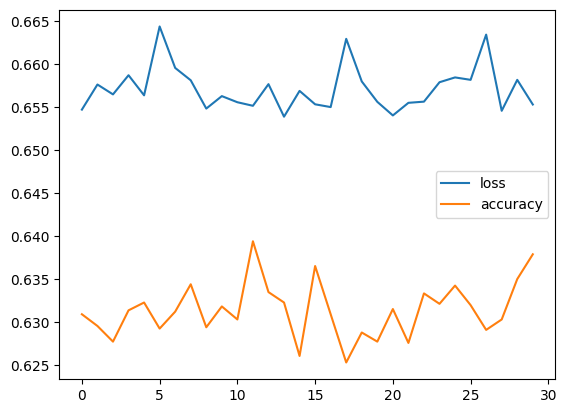

In [57]:
import matplotlib as plt

pd.DataFrame(history.history).plot()


In [56]:
results = model.evaluate([player_data_matrix_testset_t, team_testdata_matrix_t], test_df_p["won"])

104/104 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6294
